In [1]:
import os
import time

from nptyping import NDArray

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import arviz as az

from jax.scipy.special import logsumexp
from jax import random
import jax.numpy as jnp
from jax import vmap
import jax

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from numpyro.contrib.nested_sampling import NestedSampler
from numpyro.distributions import constraints
from numpyro.infer import Predictive, SVI, Trace_ELBO, MCMC, NUTS
from numpyro.diagnostics import autocorrelation, hpdi
from numpyro import handlers
from numpyro.contrib.control_flow import scan
from numpyro.infer.util import initialize_model, log_density
from numpyro.infer.hmc import hmc
from numpyro.infer.autoguide import AutoMultivariateNormal, AutoDiagonalNormal

import seaborn as sns
import scipy


# Load the data

In [2]:
data = pd.read_csv('data/small_df_malaria_with_covariates.csv')
data.head()

,id,country,latitude,longitude,year_start,examined,pf_pos,pf_pr,LST_Night_SD_5km,TCW_SD_5km,...,prec57a0_5km,TCB_Mean_5km,LST_Delta_SD_5km,TCB_SD_5km,LST_Day_SD_5km,LST_Day_Mean_5km,LST_Delta_Mean_5km,EVI_SD_5km,IGBP_2011_combined_forest,Pv_temperature_suitability
0,805938,Burundi,-3.11032,30.13181,2002,12,5.0,0.416667,1.615688,0.037288,...,91.599998,0.442503,4.365335,0.035782,4.094793,26.112253,12.006243,0.084885,0.0,19407.0
1,815990,Burundi,-3.17949,30.13868,2002,14,2.0,0.142857,1.391282,0.039882,...,96.239998,0.445988,4.216877,0.037949,4.256285,26.450457,11.881299,0.084996,0.0,18212.0
2,810967,Burundi,-3.03974,30.13727,2002,10,0.0,0.000000,1.486779,0.033189,...,91.000000,0.434329,4.110178,0.034985,4.007199,26.132448,11.471465,0.084178,0.0,17868.0
3,805449,Burundi,-3.10559,30.12975,2002,14,9.0,0.642857,1.615688,0.037288,...,91.599998,0.442503,4.365335,0.035782,4.094793,26.112253,12.006243,0.084885,0.0,19407.0
4,810209,Burundi,-3.16618,30.14546,2002,14,0.0,0.000000,1.445834,0.038757,...,94.239998,0.440252,4.190187,0.037552,4.142469,26.013147,11.710049,0.085187,0.0,17135.0


In [3]:
# remove outliers
data = data[data['examined'] <= 2000]

INFO[2022-05-20 10:14:58,444]: Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO[2022-05-20 10:14:58,445]: NumExpr defaulting to 8 threads.


In [4]:
covs = ['latitude', 'longitude',
       'LST_Night_SD_5km', 'TCW_SD_5km', 'TCW_Mean_5km',
       'LST_Night_Mean_5km', 'DMSP_F18_5km', 'EVI_Mean_5km', 'GPW_2013',
       'accessibility_50k_5km', 'PET_1950-2000_5km', 'Elev_5km',
       'AI_1950-2000_5km', 'prec57a0_5km', 'TCB_Mean_5km', 'LST_Delta_SD_5km',
       'TCB_SD_5km', 'LST_Day_SD_5km', 'LST_Day_Mean_5km',
       'LST_Delta_Mean_5km', 'EVI_SD_5km', 'IGBP_2011_combined_forest',
       'Pv_temperature_suitability']

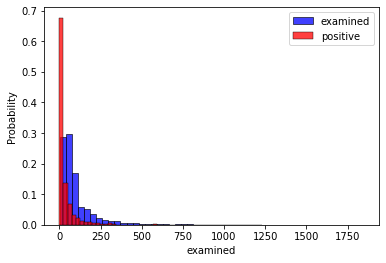

In [5]:
sns.histplot(data['examined'], stat='probability', bins=50, label='examined', color='blue')
sns.histplot(data['pf_pos'], stat='probability', bins=50, label='positive', color='red')
plt.legend()
plt.show()

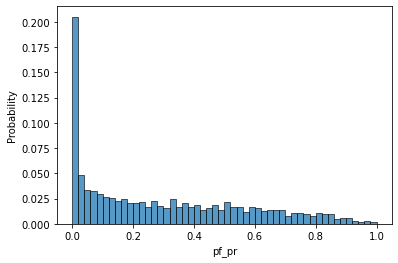

In [6]:
sns.histplot(data['pf_pr'], stat='probability', bins=50)
plt.show()

In [7]:
def emplogit_counts(Y, N):
    num = Y + 0.5
    denom = (N-Y) + 0.5
    return np.log(num/denom)

In [8]:
data['prevalence'] = np.array(list(map(emplogit_counts,data.pf_pos.values, data.examined.values)))

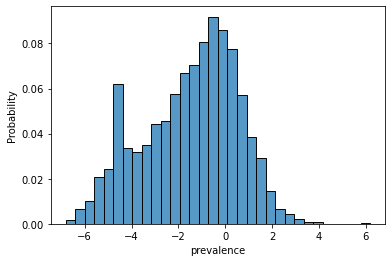

In [9]:
sns.histplot(data['prevalence'], stat='probability')
plt.show()

In [10]:
X = data[covs].values

# Standardise the predictors

In [11]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [12]:
x = X[:,:]
print(x.shape)

(3103, 23)


# Define the output variables

In [13]:
n_obs = data['examined'].values
y = data['pf_pos'].values

print(y.shape)
print(n_obs.shape)

(3103,)
(3103,)


# Binomial regression

In [15]:
def prev_model(n_obs=None, y=None, x=None):
    # fixed effects
    b0 = numpyro.sample('b0', dist.Normal(0, 1))
    b1 = numpyro.sample('b1', dist.Normal(0, 1), sample_shape=(x.shape[1],))
#     print(b0, b1)
    lp = numpyro.deterministic("lp", b0 + x.dot(b1)) # prevalence

    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp)) # prevalence
     
    numpyro.sample("obs", dist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)
#     numpyro.sample("obs", dist.NegativeBinomialLogits(total_count = n_obs, logits=lp), obs=y)


# Regression with MCMC

In [16]:
kernel = NUTS(prev_model)
mcmc = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=1)
mcmc.run(random.PRNGKey(0), n_obs=jnp.array(n_obs), y=jnp.array(y), x=jnp.array(x))
mcmc.print_summary()
samples = mcmc.get_samples()  

INFO[2022-05-20 10:31:40,042]: Unable to initialize backend 'tpu_driver': Not found: Unable to find driver in registry given worker: 
INFO[2022-05-20 10:31:40,044]: Unable to initialize backend 'gpu': Not found: Could not find registered platform with name: "cuda". Available platform names are: Host Interpreter
INFO[2022-05-20 10:31:40,047]: Unable to initialize backend 'tpu': Invalid argument: TpuPlatform is not available.
sample: 100%|██████████| 2000/2000 [01:20<00:00, 24.80it/s, 1023 steps of size 3.91e-03. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     -1.05      0.01     -1.05     -1.06     -1.04   1398.93      1.00
     b1[0]     -0.08      0.01     -0.08     -0.10     -0.07    368.19      1.00
     b1[1]     -0.64      0.01     -0.64     -0.66     -0.62    405.54      1.00
     b1[2]    -20.27      0.63    -20.29    -21.30    -19.28    538.73      1.00
     b1[3]      0.31      0.01      0.31      0.30      0.33    637.74      1.00
     b1[4]     -0.39      0.02     -0.39     -0.43     -0.35    454.11      1.01
     b1[5]     15.76      0.62     15.72     14.73     16.75    512.09      1.00
     b1[6]      0.07      0.01      0.07      0.06      0.08    748.47      1.01
     b1[7]      0.47      0.01      0.47      0.45      0.48    564.90      1.01
     b1[8]     -0.27      0.01     -0.27     -0.28     -0.26   1086.15      1.00
     b1[9]     -0.12      0.01     -0.12     -0.14     -0.11   1468.23      1.00
    b1[10]      0.03      0

In [21]:
b0_hmc = samples['b0'].mean()
b1_hmc = samples['b1'].mean(axis=0)
print(b0_hmc)
print(b1_hmc)

-1.0500107
[ -0.08363403  -0.6382774  -20.273544     0.3124797   -0.3942977
  15.757878     0.07176345   0.46549517  -0.2685796   -0.12472082
   0.02664726   0.15434504  -0.1404103    0.46633413  -0.3145082
  12.574689    -0.2909507    0.90524644   3.5791357  -12.539405
  -0.03231758  -0.13921197   0.16171844]


In [22]:
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
predictive = Predictive(prev_model, samples)
predictions = predictive(rng_key_predict, n_obs = jnp.array(n_obs), x = jnp.array(x))['obs']


mean_prediction = np.mean(predictions, axis=0)
percentiles50 = np.percentile(predictions, [25.0, 75.0], axis=0)
percentiles75 = np.percentile(predictions, [12.50, 87.50], axis=0)
percentiles90 = np.percentile(predictions, [5.0, 95.0], axis=0)

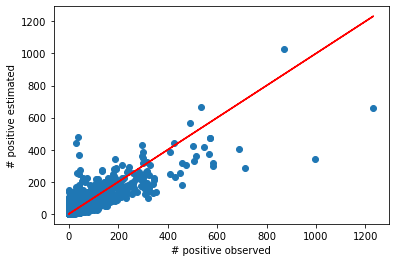

In [23]:
plt.scatter(y, mean_prediction)
plt.xlabel('# positive observed')
plt.ylabel('# positive estimated')
plt.plot(y, y, color='red')
plt.show()

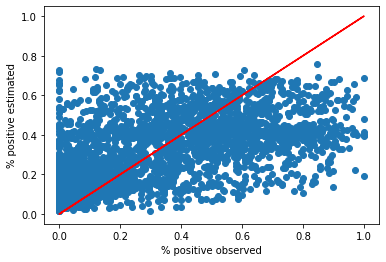

In [24]:
plt.scatter(y/n_obs, mean_prediction/n_obs)
plt.xlabel('% positive observed')
plt.ylabel('% positive estimated')
plt.plot(y/n_obs, y/n_obs, color='red')
plt.show()

# Using HMC posterior as TI reference

path density

lambda(log-like1 + log_prior) + (1-lambda)log_ref_density

In [25]:
# using mcmc samples
posterior_samples = samples

mu_ref =  [posterior_samples['b0'].mean(), 
           posterior_samples['b1'].mean(axis=0)]

sigma_ref =  [posterior_samples['b0'].std(), 
           posterior_samples['b1'].std(axis=0)]

In [26]:
samples = jnp.append(jnp.reshape(posterior_samples['b0'], (posterior_samples['b1'].shape[0],1)),
                                 posterior_samples['b1'], axis=1)
print(samples.shape)

(1000, 24)


In [33]:
diag_approx = True

if diag_approx:
    # using diagonal approximation
    
    sigma_ref_tmp = jnp.append(sigma_ref[0], sigma_ref[1])
#     sigma_ref = sigma_ref_tmp

    posterior = {'mu': mu_ref, 'cov': jnp.diag(sigma_ref_tmp**2), 'y': y, 'x': X}
    posterior.update({'covinv': jnp.linalg.inv(posterior['cov'])})
    posterior.update({'log_det_cov': jnp.log(sigma_ref_tmp**2).sum()})
else:
    # using full covariance matrix
    posterior = {'mu': mu_ref, 'cov': jnp.array(np.cov(np.array(samples[:,:]), rowvar = False)), 'y': y, 'x': X}
    posterior.update({'covinv': jnp.linalg.inv(posterior['cov'])})
    posterior.update({'log_det_cov': jnp.log(np.linalg.det(posterior['cov']))})

In [34]:
posterior['log_det_cov']

DeviceArray(-172.94719, dtype=float32)

# Reference using a Laplace approximation

https://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/06/lecture-06.pdf equation 3

https://www.statlect.com/fundamentals-of-statistics/linear-regression-maximum-likelihood

In [35]:
def Logf(posterior):
    theta_tmp = posterior['mu']
    
    b0 = theta_tmp[0]
    b1 = theta_tmp[1:][0]
    
    x = posterior['x']
    y = posterior['y']
    N = len(y)
    

    log_prior = dist.Normal(0,1).log_prob(b0)   
    log_prior += dist.Normal(0,1).log_prob(b1).sum()
    
    lp = b0 + x.dot(b1)
#     theta = jax.nn.sigmoid(lp)
     
    # log likelihood = sum of log likelihoods#
    log_likelihood = dist.BinomialLogits(total_count = n_obs, logits=lp).log_prob(y).sum()

    return log_likelihood + log_prior    


def LogLaplaceCovariance(posterior):
    
    result = 1/2 * len(posterior['mu']) * jnp.log(2*np.pi) 
    result += 1/2 * posterior['log_det_cov']#jnp.log(jnp.linalg.det(posterior['cov']))
    result += Logf(posterior)
    return result

In [36]:
f0 = Logf(posterior)
log_zref = LogLaplaceCovariance(posterior)

print('q(theta_hat)', f0)
print('log(z_ref)=', log_zref)

q(theta_hat) -45225.023
log(z_ref)= -45309.66


# Thermodynamic Integration

In [37]:
def ref_TI_laplace(y = None, x = None, n_obs=n_obs, lambda_ti=1.0):
        
    n = x.shape[1]    
    mu_ref = posterior['mu']
    
    # sample from some distribution
    b0 = numpyro.sample('b0', dist.Normal(0, 1))
    
#     with numpyro.plate('num_covs', n):
#         b1 = numpyro.sample('b1', dist.Normal(0,1))
        
    b1 = numpyro.sample('b1', dist.Normal(0, 1), sample_shape=(n,))
    
    lp = numpyro.deterministic("lp", b0 + x.dot(b1)) # prevalence


#     theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp)) # prevalence
     
    numpyro.sample("obs", dist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)
    
    lik = numpyro.deterministic('lik', dist.BinomialLogits(total_count = n_obs, logits=lp).log_prob(y).sum())

    # remove the log-prob added by the prior
    lp_prior = dist.Normal(0, 1).log_prob(b0)   
    lp_prior += dist.Normal(0, 1).log_prob(b1).sum()
    lp_prior = numpyro.deterministic('lp_prior',  lp_prior)

    
    # log-prob reference

#     theta_ = jnp.append(jnp.array([(b0 - mu_ref[0]), (b1 - mu_ref[1])]).flatten())
    theta_ = jnp.append(b0 - mu_ref[0], b1 - mu_ref[1])
    
    lp_lik_ref = f0 - 0.5 * (jnp.matmul(jnp.matmul(theta_,posterior['covinv']),theta_))
    
    tmp = numpyro.deterministic('tmp', (1 - lambda_ti) * (lp_lik_ref - lp_prior))
    tmp2 = numpyro.deterministic('tmp2',(lp_lik_ref - lp_prior))
    tmp3 = numpyro.deterministic('tmp3',(1 - lambda_ti))

#     print(tmp, tmp2, tmp3)
    
    if lambda_ti != 0.0:
        numpyro.factor('likelihood1',  lambda_ti * lik)
    if lambda_ti != 1.0:
        numpyro.factor('likelihood2',  
                       (1 - lambda_ti) * (lp_lik_ref - lp_prior)
                      )
    
    # generated quantities
    q0 = numpyro.deterministic('q0', lp_lik_ref)
    q1 = numpyro.deterministic('q1', lik + lp_prior)
    qdiff = numpyro.deterministic('qdiff',  q1-q0)
   
    
kernel = NUTS(ref_TI_laplace,  target_accept_prob=0.8)
mcmc = MCMC(kernel, num_warmup = 1000, num_samples = 4000, num_chains = 1)

# Test for lambda = 0

In [38]:
mcmc.run(random.PRNGKey(0), y = jnp.array(y), x = jnp.array(x), n_obs=jnp.array(n_obs), lambda_ti = 0.0)
mcmc.print_summary()
samples = mcmc.get_samples()  

sample: 100%|██████████| 5000/5000 [02:40<00:00, 31.19it/s, 1023 steps of size 5.29e-03. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     -1.05      0.00     -1.05     -1.05     -1.04   6034.78      1.00
     b1[0]     -0.10      0.01     -0.10     -0.11     -0.09   3756.77      1.00
     b1[1]     -0.65      0.01     -0.65     -0.66     -0.64   3617.47      1.00
     b1[2]    -25.37      0.44    -25.38    -26.10    -24.67   3028.41      1.00
     b1[3]      0.32      0.01      0.32      0.31      0.32   4384.31      1.00
     b1[4]     -0.40      0.01     -0.40     -0.42     -0.38   2977.31      1.00
     b1[5]     18.57      0.42     18.57     17.93     19.27   3014.73      1.00
     b1[6]      0.07      0.00      0.07      0.06      0.07   5042.47      1.00
     b1[7]      0.47      0.01      0.47      0.46      0.48   3481.95      1.00
     b1[8]     -0.27      0.00     -0.27     -0.28     -0.26   5283.67      1.00
     b1[9]     -0.13      0.00     -0.13     -0.13     -0.12   6145.93      1.00
    b1[10]      0.02      0

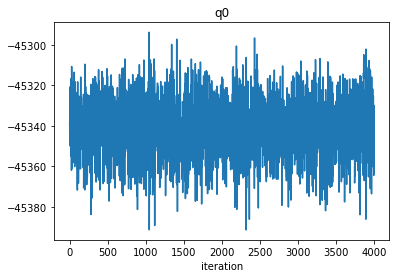

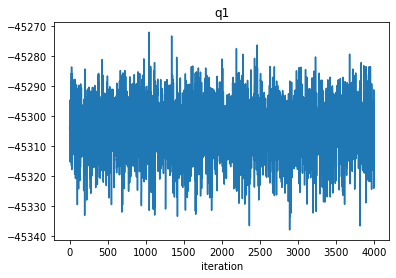

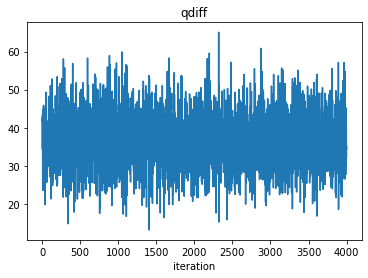

In [39]:
plt.plot(samples['q0'])
plt.xlabel('iteration')
plt.title('q0')
plt.show()
plt.plot(samples['q1'])
plt.xlabel('iteration')
plt.title('q1')
plt.show()
plt.plot(samples['qdiff'])
plt.xlabel('iteration')
plt.title('qdiff')
plt.show()

# Test for lambda = 1

In [40]:
mcmc.run(random.PRNGKey(0), y = jnp.array(y), x = jnp.array(x), n_obs=jnp.array(n_obs), lambda_ti = 1.0)
mcmc.print_summary()
samples = mcmc.get_samples()  

sample: 100%|██████████| 5000/5000 [06:31<00:00, 12.78it/s, 1023 steps of size 3.04e-03. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     -1.05      0.00     -1.05     -1.06     -1.04   5010.64      1.00
     b1[0]     -0.13      0.01     -0.13     -0.14     -0.12   1220.14      1.00
     b1[1]     -0.69      0.01     -0.69     -0.70     -0.68   1137.31      1.00
     b1[2]    -28.04      0.56    -28.05    -28.91    -27.06   1188.49      1.00
     b1[3]      0.32      0.01      0.32      0.31      0.33   1661.75      1.00
     b1[4]     -0.35      0.02     -0.35     -0.38     -0.32   1211.51      1.00
     b1[5]     18.90      0.53     18.90     18.02     19.74   1513.42      1.00
     b1[6]      0.06      0.00      0.06      0.05      0.06   2428.44      1.00
     b1[7]      0.47      0.01      0.47      0.46      0.48   1705.90      1.00
     b1[8]     -0.27      0.00     -0.27     -0.27     -0.26   3682.03      1.00
     b1[9]     -0.13      0.00     -0.13     -0.14     -0.13   4569.20      1.00
    b1[10]      0.02      0

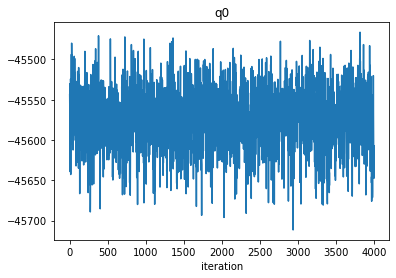

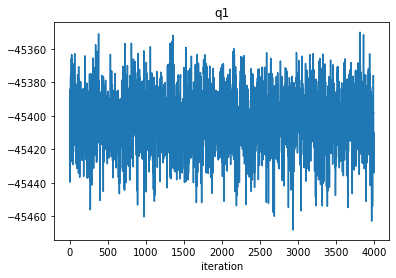

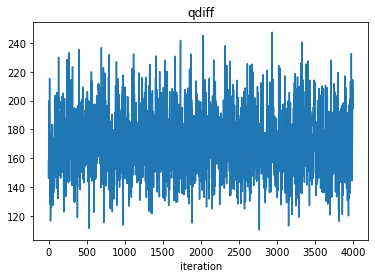

In [41]:
plt.plot(samples['q0'])
plt.xlabel('iteration')
plt.title('q0')
plt.show()
plt.plot(samples['q1'])
plt.xlabel('iteration')
plt.title('q1')
plt.show()
plt.plot(samples['qdiff'])
plt.xlabel('iteration')
plt.title('qdiff')
plt.show()

# Full TI

In [42]:
def TI(lambda_vals = jnp.arange(0.0,1.1,0.1)):
    kernel = NUTS(ref_TI_laplace,  target_accept_prob=0.8)
    mcmc = MCMC(kernel, num_warmup = 1000, num_samples = 1000, num_chains = 1)
    
    samples, integrand = [], []
    for lambda_i in lambda_vals:
        
        mcmc.run(random.PRNGKey(0), y = jnp.array(y), x = jnp.array(x), n_obs=jnp.array(n_obs), lambda_ti = lambda_i)
        samples_i = mcmc.get_samples() 
        

        log_qdiff = samples_i['qdiff']
        integrand_i = jnp.nanmean(log_qdiff)
        
        print('lambda=', lambda_i, integrand_i)
        
        integrand.append([lambda_i, integrand_i])
        samples.append(samples_i)
        
    return integrand, samples
        

In [43]:
integrand, samples = TI() 

  0%|          | 0/2000 [00:00<?, ?it/s]

lambda= 0.0 36.543564


  0%|          | 0/2000 [00:00<?, ?it/s]

lambda= 0.1 41.745564


  0%|          | 0/2000 [00:00<?, ?it/s]

lambda= 0.2 47.393707


  0%|          | 0/2000 [00:00<?, ?it/s]

lambda= 0.3 54.096157


  0%|          | 0/2000 [00:00<?, ?it/s]

lambda= 0.4 61.67413


  0%|          | 0/2000 [00:00<?, ?it/s]

lambda= 0.5 71.00807


  0%|          | 0/2000 [00:00<?, ?it/s]

lambda= 0.6 82.09056


  0%|          | 0/2000 [00:00<?, ?it/s]

lambda= 0.7 96.2069


  0%|          | 0/2000 [00:00<?, ?it/s]

lambda= 0.8 113.899635


  0%|          | 0/2000 [00:00<?, ?it/s]

lambda= 0.90000004 137.56635


sample: 100%|██████████| 2000/2000 [02:26<00:00, 13.66it/s, 1023 steps of size 3.04e-03. acc. prob=0.93]


lambda= 1.0 170.65845


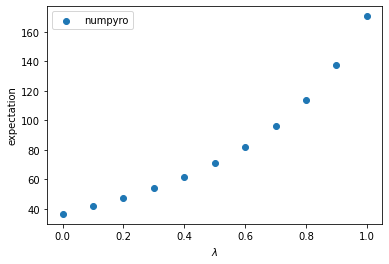

In [44]:
integrand = np.array(integrand)
lambda_vals, TI_integrand = integrand.T[0, :], integrand.T[1, :]
plt.scatter(lambda_vals, TI_integrand, label='numpyro') # normal scale
# plt.scatter(z_ti_stan.keys(), stan_expects , label='stan') # normal scale
plt.legend()
plt.xlabel('$\lambda$')
plt.ylabel('expectation')
plt.show()

# Fit a cubic spline and integrate

In [45]:
import scipy

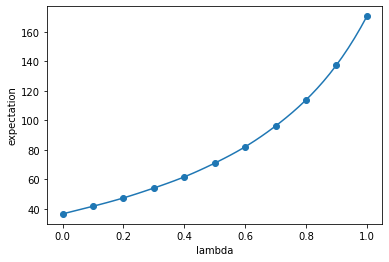

80.64727509268239

In [48]:
tck = scipy.interpolate.splrep(lambda_vals, TI_integrand, s=0)
xnew = np.linspace(0, 1)
ynew = scipy.interpolate.splev(xnew, tck, der=0)
plt.plot(xnew,ynew)
plt.scatter(lambda_vals, TI_integrand)
plt.xlabel('lambda')
plt.ylabel('expectation')
plt.show()
# calculate exponent of the integral of the interpolated line
logzExtra = scipy.interpolate.splint(lambda_vals[0], lambda_vals[-1], tck, full_output=0)
logzExtra


# Finally we can calculate log(z) = log(z_ref) + log(z_extra)

In [49]:
log_z = log_zref + logzExtra

In [50]:
print(log_z)

-45229.01
